In [2]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import time

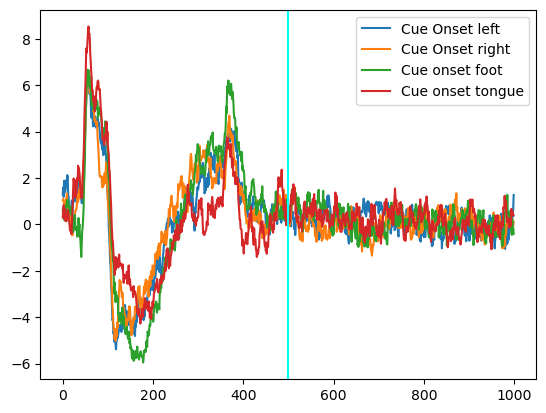

In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3
y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [4]:

## Preprocessing the dataset

X_train_valid_prep = X_train_valid[:,:,0:500]
X_test_prep = X_test[:,:,0:500]



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)



Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 500, 1)
Shape of validation set after adding width info: (500, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (1615, 500, 1, 22)
Shape of validation set after dimension reshaping: (500, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)


In [5]:
 #[conv - batchnorm -relu-pool]xN - [affine]xM - [softmax] 
# Define the shallow CNN model
import tensorflow.keras.backend as K

# Clear the current TensorFlow session
K.clear_session()

drop = 0.7

ShallowCNN = Sequential()
ShallowCNN.add(Conv2D(40, (25, 1), activation='elu', input_shape=(500, 1,22)))
ShallowCNN.add(BatchNormalization())
ShallowCNN.add(Dropout(drop))
ShallowCNN.add(AveragePooling2D(pool_size=(5, 1), padding='same',strides=(5, 1)))

ShallowCNN.add(Conv2D(40, (25, 1), activation='elu'))
ShallowCNN.add(BatchNormalization())
ShallowCNN.add(Dropout(drop))
ShallowCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ShallowCNN.add(Conv2D(25, (3, 1), activation='elu'))
ShallowCNN.add(BatchNormalization())
ShallowCNN.add(Dropout(drop))
ShallowCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ShallowCNN.add(Flatten())
ShallowCNN.add(Dense(100, activation='elu'))
ShallowCNN.add(Dense(4, activation='softmax'))  # Assuming 4 output classes

# Printing the model summary
ShallowCNN.summary()


/Users/haoyuluo/anaconda3/envs/new183/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 476, 1, 40)     │        22,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 476, 1, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 476, 1, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 96, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 1, 40)      │        40,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 1, 40)      │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 1, 40)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 36, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 1, 25)      │         3,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 1, 25)      │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 34, 1, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 17, 1, 25)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 425)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        42,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,529 (423.94 KB)

 Trainable params: 108,319 (423.12 KB)

 Non-trainable params: 210 (840.00 B)

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 500
decay_rate = 0.0001
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum,weight_decay=decay_rate)
# Specify the GPU device
with tf.device('/GPU:0'):
    # Compiling the model
    ShallowCNN.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    
    # Record training time and accuracy at each epoch
    training_time_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        # Perform training for one epoch
        
        # Print progress
        print(f"Epoch [{epoch}/{epochs}]")
        
        # Training and validating the model for one epoch
        ShallowCNN_results = ShallowCNN.fit(x_train,
                                             y_train,
                                             batch_size=64,
                                             epochs=1,
                                             validation_data=(x_valid, y_valid),
                                             verbose=True)
        # Record training time
        training_time = time.time() - start_time   
        training_time_history.append(training_time)
        train_accuracy_history.append(ShallowCNN_results.history['accuracy'])
        val_accuracy_history.append(ShallowCNN_results.history['val_accuracy'])

Epoch [0/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2430 - loss: 2.1214 - val_accuracy: 0.2960 - val_loss: 1.5898
Epoch [1/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2920 - loss: 1.8481 - val_accuracy: 0.3560 - val_loss: 1.5032
Epoch [2/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2862 - loss: 1.7479 - val_accuracy: 0.3920 - val_loss: 1.4286
Epoch [3/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3089 - loss: 1.5764 - val_accuracy: 0.3940 - val_loss: 1.3649
Epoch [4/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3500 - loss: 1.4913 - val_accuracy: 0.3820 - val_loss: 1.3334
Epoch [5/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3213 - loss: 1.4922 - val_accuracy: 0.4100 - val_loss: 1.3059
Epoch [6/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3860 - loss: 1.4241 - val_accuracy: 0.4320 - val_loss: 1.2756
Epoch [7/500]
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3485 - loss: 1.4495 - 

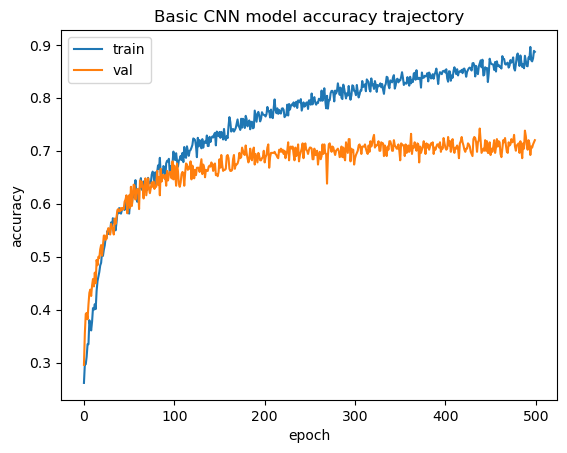

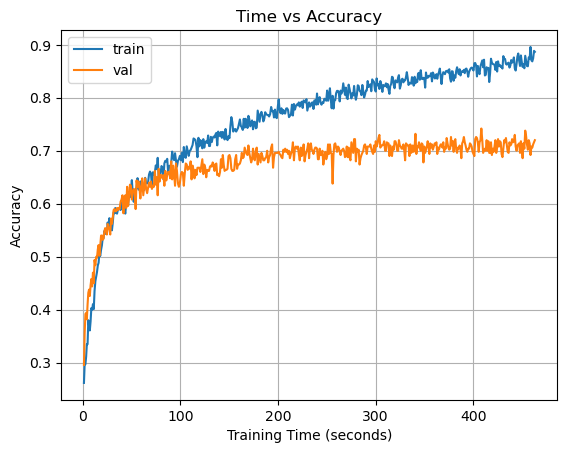

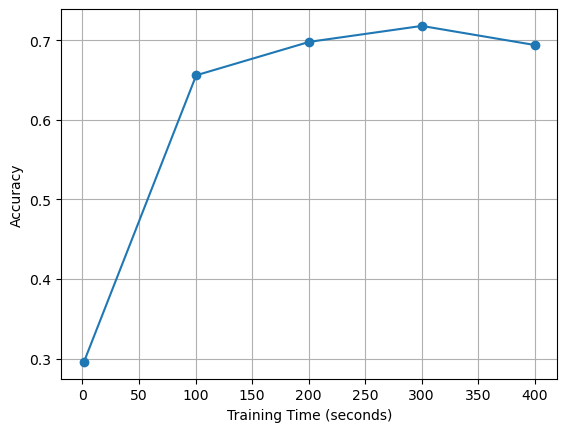

In [19]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# # Plotting loss trajectory
# plt.plot(ShallowCNN_results.history['loss'],'o')
# plt.plot(ShallowCNN_results.history['val_loss'],'o')
# plt.title('Basic CNN model loss trajectory')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# Plot time vs accuracy
plt.plot(training_time_history, train_accuracy_history)
plt.plot(training_time_history, val_accuracy_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Time vs Accuracy')
plt.grid(True)
plt.show()

training_time_history_array = np.array(training_time_history)
val_accuracy_history_array = np.array(val_accuracy_history)
intervals = np.arange(0,500,100)
indices = np.searchsorted(training_time_history_array, intervals)
sampled_training_time_history = training_time_history_array[indices]
sampled_val_accuracy_history = val_accuracy_history_array[indices]
plt.plot(sampled_training_time_history, sampled_val_accuracy_history,'-o')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)


In [20]:
## Testing the CNN model

cnn_score = ShallowCNN.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6794582605361938


## Discussion on Optimizing trend and appropriate stop time

* From the epoch-accuracy and training-time accuracy plots we can see that optimizing accuracies across all subjects can achieve an overall testing accuracy over 70% which is higher than accuracy for optimzing single subject. At around 300 epoch, the accuracy reaches its platau which correspond to a time of 800 secs. From here, the accuracy start bouncing and further training doesn't help further increasing accuracy.

In [21]:
 #[conv - batchnorm -relu-pool]xN - [affine]xM - [softmax] 
# Define the shallow CNN model
import tensorflow.keras.backend as K

# Clear the current TensorFlow session
K.clear_session()

drop = 0.3

ComplexCNN = Sequential()
ComplexCNN.add(Conv2D(40, (3, 1), activation='elu', input_shape=(500, 1,22)))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Flatten())

ComplexCNN.add(Dense(100, activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))

ComplexCNN.add(Dense(100, activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))

ComplexCNN.add(Dense(400, activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))

ComplexCNN.add(Dense(4, activation='softmax'))  # Assuming 4 output classes

# Printing the model summary
ComplexCNN.summary()



/Users/haoyuluo/anaconda3/envs/new183/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 1, 40)     │         2,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 498, 1, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 498, 1, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 249, 1, 40)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 1, 40)     │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 247, 1, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 247, 1, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 124, 1, 40)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 122, 1, 40)     │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 122, 1, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 122, 1, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 61, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 59, 1, 40)      │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 59, 1, 40)      │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 59, 1, 40)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 30, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 1, 40)      │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 1, 40)      │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 1, 40)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 14, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │             

 Total params: 133,444 (521.27 KB)

 Trainable params: 131,844 (515.02 KB)

 Non-trainable params: 1,600 (6.25 KB)

In [139]:
learning_rate = 1e-3
epochs = 400
decay_rate = 0.0005
momentum = 0.9
optimizer = Adam(learning_rate=learning_rate, weight_decay=decay_rate,use_ema=True,ema_momentum=momentum)
# Specify the GPU device
with tf.device('/GPU:1'):
    # Compiling the model
    ComplexCNN.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    
    # Record training time and accuracy at each epoch
    training_time_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        # Perform training for one epoch
        
        # Print progress
        print(f"Epoch [{epoch}/{epochs}]")
        
        # Training and validating the model for one epoch
        ComplexCNN_results = ComplexCNN.fit(x_train,
                                             y_train,
                                             batch_size=64,
                                             epochs=1,
                                             validation_data=(x_valid, y_valid),
                                             verbose=True)
        # Record training time
        training_time = time.time() - start_time   
        training_time_history.append(training_time)
        train_accuracy_history.append(ComplexCNN_results.history['accuracy'])
        val_accuracy_history.append(ComplexCNN_results.history['val_accuracy'])

Epoch [0/400]
26/26 [==============================] - 9s 109ms/step - loss: 1.8563 - accuracy: 0.2793 - val_loss: 1.4209 - val_accuracy: 0.2960
Epoch [1/400]
26/26 [==============================] - 2s 93ms/step - loss: 1.6138 - accuracy: 0.3443 - val_loss: 1.3802 - val_accuracy: 0.3380
Epoch [2/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.5951 - accuracy: 0.3406 - val_loss: 1.3097 - val_accuracy: 0.3860
Epoch [3/400]
26/26 [==============================] - 2s 93ms/step - loss: 1.5246 - accuracy: 0.3659 - val_loss: 1.2931 - val_accuracy: 0.4080
Epoch [4/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.4832 - accuracy: 0.3827 - val_loss: 1.2743 - val_accuracy: 0.4600
Epoch [5/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.3885 - accuracy: 0.4409 - val_loss: 1.3596 - val_accuracy: 0.4520
Epoch [6/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.3595 - accuracy: 0.4303 - val_loss: 1.2455 - val_accuracy

In [1]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# # Plotting loss trajectory
# plt.plot(ShallowCNN_results.history['loss'],'o')
# plt.plot(ShallowCNN_results.history['val_loss'],'o')
# plt.title('Basic CNN model loss trajectory')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# Plot time vs accuracy
plt.plot(training_time_history, train_accuracy_history)
plt.plot(training_time_history, val_accuracy_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Time vs Accuracy')
plt.grid(True)
plt.show()

mask = training_time_history % 100 == 0
sampled_training_time_history = training_time_history[mask]
sampled_training_accuracy_history = train_accuracy_history[mask]

plt.plot(sampled_training_time_history, sampled_training_accuracy_history)
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')


NameError: name 'train_accuracy_history' is not defined

In [141]:
## Testing the CNN model

cnn_score = ComplexCNN.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6772009134292603
